In [1]:
%pylab inline
import numpy as np
import os
import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
!arch

i386


In [3]:
!futhark c --library bench_epiloss.fut

Warning at bench_epiloss.fut:24:13-13:
  Unused variable "i" .


In [4]:
!build_futhark_ffi bench_epiloss

Detected platform: darwin
Detected backend:  c


In [7]:
from futhark_ffi import Futhark
import _bench_epiloss
epinet = Futhark(_bench_epiloss)
w = np.loadtxt('weights.txt').astype('f')

In [8]:
from tvb.simulator.models import Epileptor

In [9]:
z = (np.random.randn(76)/10 + 3.0).astype('f')
dt = 0.1
nt = 50000
zt = epinet.from_futhark(epinet.run_z_array(nt, dt, z, w))
lfp = zt[:,:,3] - zt[:,:,0]

In [10]:
%%timeit
epinet.from_futhark(epinet.run_z_array(nt, 0.1, z, w))

86 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


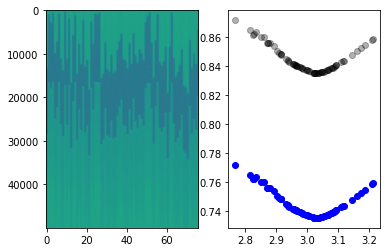

In [11]:
subplot(121); imshow(lfp,aspect='auto',vmin=-5,vmax=5)
subplot(122);
plot(z, epinet.from_futhark(epinet.forward_array(zt)), 'bo')
plot(z, lfp.std(axis=0) + 0.1, 'ko', alpha=0.3)

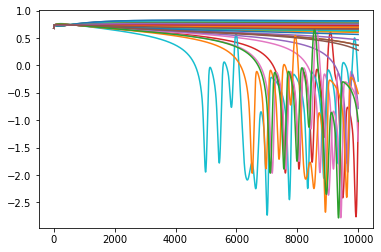

In [12]:
tf = 100
dt = 1e-2
zt = epinet.from_futhark(epinet.run_z_array(int(tf/dt), dt, z, w))
lfp = zt[:,:,3] - zt[:,:,0]
plot(lfp);

In [13]:
model = Epileptor(
    a = np.r_[1.0],
    b = np.r_[3.0],
    c = np.r_[1.0],
    d = np.r_[5.0],
    r = np.r_[0.00015],
    s = np.r_[4.0],
    Iext = np.r_[3.1],
    slope = np.r_[0.0],
    Iext2 = np.r_[0.45],
    tau = np.r_[10.0],
    aa = np.r_[6.0],
    bb = np.r_[2.0],
    Kvf = np.r_[0.0],
    Kf = np.r_[0.00],
    Ks = np.r_[0.00],
    tt = np.r_[1.0],
    modification = np.r_[False],
    x0 = np.r_[-2.0],
)

def compare_dx(x):
    c = 0.01
    dx1 = model.dfun(x.reshape(6,1,1), np.r_[c,c].reshape(2,1)).reshape(6)
    dx2 = epinet.from_futhark(epinet.node_eval(x.astype('f'), c,c))
    return dx1-dx2

for i in tqdm.trange(76):
    acc = []
    for x in zt[:,i,:]:
        acc.append(np.abs(compare_dx(x)))
    acc = np.array(acc)
    if np.any(acc>0.01):
        print(i, acc.sum(axis=0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:35<00:00,  2.14it/s]


WARNING  File 'hemispheres' not found in ZIP.
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
1.65 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16.6 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(10000.0, 'steps')

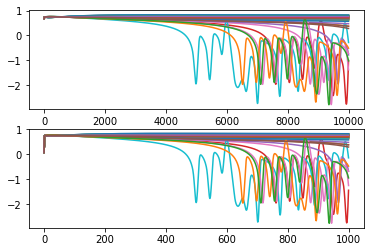

In [14]:
from tvb.simulator.lab import *
initial = np.r_[-1.5, -11.3, 3.0, -0.82, 0.04, -0.15]
initial = np.zeros((100, 1, 76, 1)) + initial[:, None, None]
initial[:,2] = z[:,None]
sim = simulator.Simulator(
    connectivity=connectivity.Connectivity.from_file(),
    coupling=coupling.Difference(a=np.r_[0.0]),
    model=model,
    integrator=integrators.HeunDeterministic(dt=dt),
    initial_conditions=initial,
    monitors=[monitors.TemporalAverage(period=0.1)]
)
sim.configure()
(t,y),*_ = sim.run(simulation_length=100)
%timeit sim.run(simulation_length=100)
%timeit epinet.from_futhark(epinet.run_z_array(int(tf/dt), dt, z, w))
subplot(211); plot(lfp)
subplot(212); plot(y[:,0,:,0]);
100/dt, 'steps'

Let's check the online and regular loss functions,

In [15]:
epinet.loss(nt,dt,w,z,z+1e-2), epinet.loss_online(nt,dt,w,z,z+1e-2)

(610.7182006835938, 610.7116088867188)

Close enough

We can check the forward and backward derivatives against each other,

In [16]:
nt = 100
losses = [
    epinet.from_futhark(epinet.vjp_loss(nt,dt,w,z,z+1e-2)),
    epinet.from_futhark(epinet.jvp_loss(nt,dt,w,z,z+1e-2)),
    epinet.from_futhark(epinet.vjp_loss_online(nt,dt,w,z,z+1e-2)),
    epinet.from_futhark(epinet.jvp_loss_online(nt,dt,w,z,z+1e-2))  ,
]
for l in losses[1:]:
    np.testing.assert_allclose(losses[0], l, 1e-6, 1e-3)

In [17]:
nt = 1000
%timeit l2 = epinet.loss(nt,dt,w,z,z+1e-2)
%timeit l2 = epinet.loss_online(nt,dt,w,z,z+1e-2)

1.04 ms ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.45 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As a baseline, we can check against numerical difference,

In [18]:
nt = 100
zh = z + 1e-2
l2_nd = []
l2 = epinet.loss(nt,dt,w,z,zh)
h = 1e-1
for i in range(76):
    zh_ = zh.copy()
    zh_[i] += h
    l2_nd.append((epinet.loss(nt,dt,w,z,zh_) - l2)/h)
l2_nd = np.array(l2_nd)
l2 = epinet.from_futhark(epinet.jvp_loss(nt,dt,w,z,zh))
np.testing.assert_allclose(l2_nd, l2, 1e-3, 1e-1)

Forward mode is not as efficient as we'd like because it takes more time than equivalent numerical differences,

In [19]:
for nt in [1, 10, 100, 1000]:
    %timeit -r 1 l2 = epinet.from_futhark(epinet.jvp_loss(nt,dt,w,z,z+1e-2))
    %timeit -r 1 l2 = epinet.from_futhark(epinet.jvp_loss_online(nt,dt,w,z,z+1e-2))
    print()

48.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
42.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)

1.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
3.55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)

16.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)

350 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
389 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



Backwards mode is fast for a short number of time steps, but memory is an issue for longer sims.

In [20]:
for nt in [8,16,32,64,100,128]:
    %timeit -r 1 -n 50 l2 = epinet.from_futhark(epinet.vjp_loss(nt,dt,w,z,z+1e-2))
    %timeit -r 1 -n 50 l2 = epinet.from_futhark(epinet.vjp_loss_online(nt,dt,w,z,z+1e-2))
    print()

63.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
73.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)

96.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
134 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)

229 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
219 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)

693 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
416 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)

1.61 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
641 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)

3.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)
837 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 50 loops each)



this isn't linear because of memory usage, so there's a cross over point around nt=32, for the batch version, while the online form is better for longer runs:

In [ ]:
for nt in [1, 10, 100, 1000, 10000]:
    %timeit -r 1 l2 = epinet.loss(nt,dt,w,z,z+1e-2)
    %timeit -r 1 l2 = epinet.loss_online(nt,dt,w,z,z+1e-2)
    %timeit -r 1 l2 = epinet.from_futhark(epinet.vjp_loss_online(nt,dt,w,z,z+1e-2))
    %timeit -r 1 l2 = epinet.from_futhark(epinet.jvp_loss(nt,dt,w,z,z+1e-2))
    print()

13.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
14.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
22.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
48.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)

22.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
36.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
80.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


Reverse AD with online loss is a good approach, as it is just over 2x cost of the loss itself. This might be something to pursue else where, i.e. when comparing time series with sum squared error, do it in online fashion.

We can look at work precision. Well, at least, convergence.

In [ ]:
tf = 100
dt = 0.001 # ms
l2 = epinet.from_futhark(epinet.jvp_loss(int(tf/dt),dt,w,z,z+1e-2))

In [ ]:
dts = dt * 2**np.r_[:8:0.1]
l2s = [epinet.from_futhark(epinet.jvp_loss(int(tf/dt_),dt_,w,z,z+1e-2))
       for dt_ in dts]
l2s = np.array(l2s)
sse = np.sum((l2s - l2)**2,axis=1)

In [ ]:
loglog(dts, sse, 'x')

In [ ]:
subplot(121); imshow(l2s.T)
subplot(122); plot(l2); plot(l2s[40]);

Interesting that the "true" solution is different from most, until the simulation diverges at around dt=0.128.